# Detect cancer in gigapixel pathology images

- Author : SeokHyun Kim (sk4985)
- Applied Deep Learning F2022


## Set environment

In [1]:
# Install the OpenSlide C library and Python bindings
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 20 not upgraded.
Need to get 92.5 kB of archives.
After this operation, 268 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 openslide-tools amd64 3.4.1+dfsg-2 [12.7 kB]
Fetched 92.5 kB in 0s (569 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 124016 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-2

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
import random
from sklearn.model_selection import train_test_split

In [3]:
# import packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, concatenate, Input, Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

## Download data from GCP bucket

In [4]:
# Download an train slide and tumor mask
slide_path = 'tumor_091.tif'
tumor_mask_path = 'tumor_091_mask.tif' 

slide_url = 'https://storage.googleapis.com/hw3_sk4985/%s' % slide_path
mask_url = 'https://storage.googleapis.com/hw3_sk4985/%s' % tumor_mask_path

# Download the whole slide image
if not os.path.exists(slide_path):
  !curl -O $slide_url

# Download the tumor mask
if not os.path.exists(tumor_mask_path):
  !curl -O $mask_url

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  521M  100  521M    0     0   171M      0  0:00:03  0:00:03 --:--:--  171M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 14.6M  100 14.6M    0     0  32.2M      0 --:--:-- --:--:-- --:--:-- 32.1M


In [5]:
slide = open_slide(slide_path)
print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                        slide.level_dimensions[0][0], 
                                                        slide.level_dimensions[0][1]))

tumor_mask = open_slide(tumor_mask_path)
print ("Read tumor mask from %s" % (tumor_mask_path))

print("Slide includes %d levels", len(slide.level_dimensions))
for i in range(len(slide.level_dimensions)):
    print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                             slide.level_dimensions[i], 
                                                             slide.level_downsamples[i]))
    assert tumor_mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
    assert tumor_mask.level_dimensions[i][1] == slide.level_dimensions[i][1]

# Verify downsampling works as expected
width, height = slide.level_dimensions[7]
assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]

Read WSI from tumor_091.tif with width: 61440, height: 53760
Read tumor mask from tumor_091_mask.tif
Slide includes %d levels 8
Level 0, dimensions: (61440, 53760) downsample factor 1
Level 1, dimensions: (30720, 26880) downsample factor 2
Level 2, dimensions: (15360, 13440) downsample factor 4
Level 3, dimensions: (7680, 6720) downsample factor 8
Level 4, dimensions: (3840, 3360) downsample factor 16
Level 5, dimensions: (1920, 1680) downsample factor 32
Level 6, dimensions: (960, 840) downsample factor 64
Level 7, dimensions: (480, 420) downsample factor 128


## Create functions to make train/test data

In [6]:
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.
# There is an example below of working with coordinates
# with respect to a higher zoom level.

# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

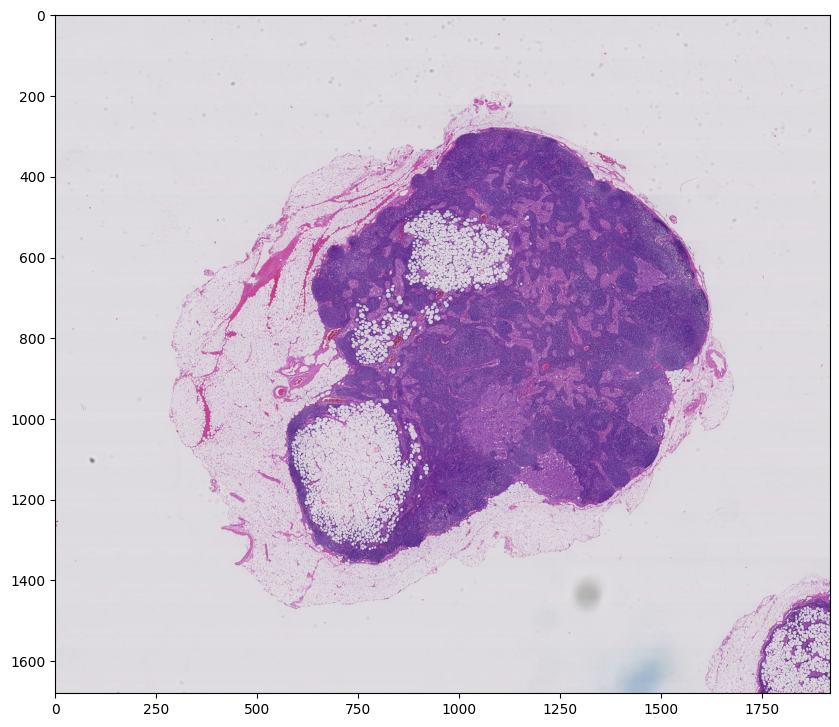

In [7]:
# Example: read the entire slide at level 5

# Higher zoom levels may not fit into memory.
# You can use the below function to extract regions from higher zoom levels 
# without having to read the entire image into ram.

# Use the sliding window approach discussed in class to collect training
# data for your classifier. E.g., slide a window across the slide (for
# starters, use a zoomed out view, so you're not working with giant images).
# Save each window to disk as an image. To find the label for that image, 
# check to the tissue mask to see if the same region contains cancerous cells.

# Important: this is tricky to get right. Carefully debug your pipeline before
# training your model. Start with just a single image, and a relatively 
# low zoom level.

slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=5, 
                         width=slide.level_dimensions[5][0], 
                         height=slide.level_dimensions[5][1])

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)

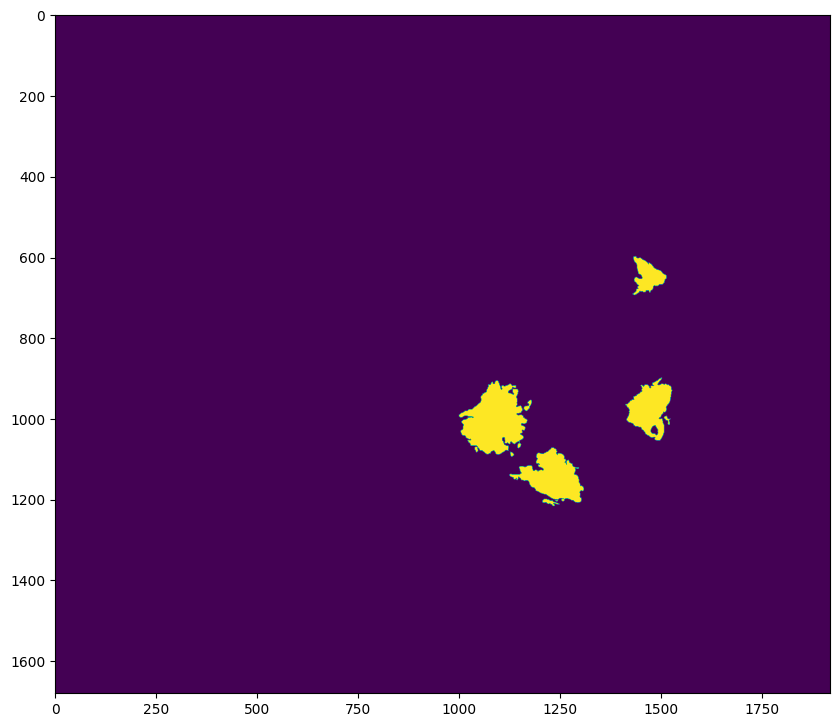

In [8]:
# Example: read the entire mask at the same zoom level
mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=5, 
                        width=slide.level_dimensions[5][0], 
                        height=slide.level_dimensions[5][1])

# Note: the program provided by the dataset authors generates a mask with R,G,B channels.
# The mask info we need is in the first channel only.
# If you skip this step, the mask will be displayed as all black.
mask_image = mask_image[:,:,0]

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(mask_image)

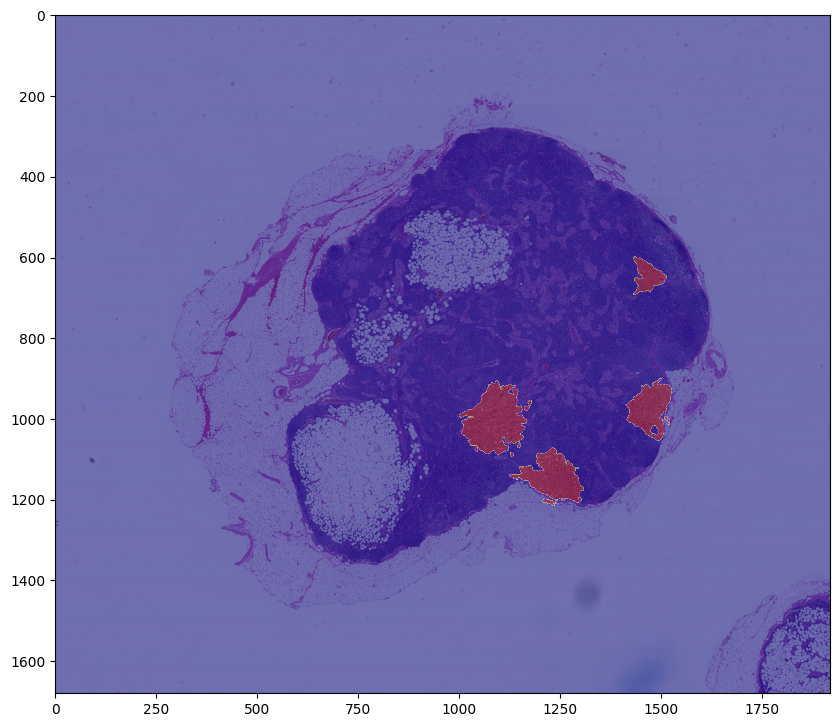

In [9]:
# Overlay them. The idea is that the mask shows the region of the slide that
# contain cancerous cells.
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='jet', alpha=0.5) # Red regions contains cancer.

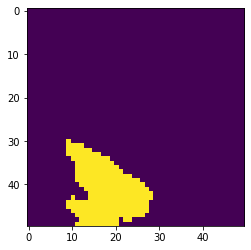

In [10]:
# Example: extract a region from the L7 downsampled image
# Notice we're multiplying the x,y coordinates by the downsample factor.
# This math can be tricky to get right, debug carefully.
# Here, we're "aiming" for the top right blob in the image above.
region = read_slide(tumor_mask, x=350 * 128, y=120 * 128, level=7, width=50, height=50)[:,:,0]
plt.imshow(region)

905504 tissue_pixels pixels (32.1 percent of the image)


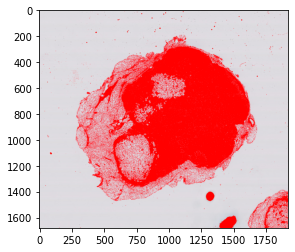

In [11]:
# As mentioned in class, we can improve efficiency by ignoring non-tissue areas 
# of the slide. We'll find these by looking for all gray regions.
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return list(zip(indices[0], indices[1]))

tissue_pixels = find_tissue_pixels(slide_image)
percent_tissue = len(tissue_pixels) / float(slide_image.shape[0] * slide_image.shape[0]) * 100
print ("%d tissue_pixels pixels (%.1f percent of the image)" % (len(tissue_pixels), percent_tissue)) 

def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked

tissue_regions = apply_mask(slide_image, tissue_pixels)
plt.imshow(tissue_regions)

In [12]:
# this function creates list of patches for multi_level from slide, tumor mask
def get_patches(slide, tumor_mask, multi_level, patch_size, center_size, tissue_pct, patch_limit):
  """inputs
  multi_level : list of two zoom levels
  patch_size : size of patch
  center_size : size of center to check tumor
  tissue_pct : criteria for percentage of tissue in image
  patch_limit : num of patches to collect
  """

  lv_temp = 4
  downsample_factor1 = 2**multi_level[0]
  downsample_factor2 = 2**multi_level[1]

  slide_image = read_slide(slide, 
                          x=0, 
                          y=0, 
                          level=lv_temp, 
                          width=slide.level_dimensions[lv_temp][0], 
                          height=slide.level_dimensions[lv_temp][1])

  # As mentioned in class, we can improve efficiency by ignoring non-tissue areas 
  # of the slide. We'll find these by looking for all gray regions.
  tissue_pixels = find_tissue_pixels(slide_image)
  tissue_regions = apply_mask(slide_image, tissue_pixels)
  tissue_regions = tissue_regions[:,:,0]

  mask_image = read_slide(tumor_mask, 
                          x=0, 
                          y=0, 
                          level=lv_temp, 
                          width=slide.level_dimensions[lv_temp][0], 
                          height=slide.level_dimensions[lv_temp][1])

  mask_image = mask_image[:,:,0]

  normal_mask_image = tissue_regions - mask_image
  normal_index = np.nonzero((normal_mask_image > 0).astype('int'))
  tumor_index = np.nonzero(mask_image)

  patch_images_lv1 = []
  patch_images_lv2 = []
  patch_labels = []


  # extract patches for tumor
  tumor_sample = random.sample(list(zip(tumor_index[1], tumor_index[0])),400)

  i = 0
  for sample in tumor_sample:
    (x0, y0) = sample

    # Notice we're multiplying the x,y coordinates by the downsample factor.
    x_lv = x0*(2**lv_temp)
    y_lv = y0*(2**lv_temp)

    slide_patch = read_slide(slide, 
                          x= x_lv - (patch_size//2)*downsample_factor1, 
                          y= y_lv - (patch_size//2)*downsample_factor1, 
                          level=multi_level[0], 
                          width=patch_size, 
                          height=patch_size)
    
    mask_patch = read_slide(tumor_mask, 
                          x= x_lv - (patch_size//2)*downsample_factor1, 
                          y= y_lv - (patch_size//2)*downsample_factor1, 
                          level=multi_level[0], 
                          width=patch_size, 
                          height=patch_size)
    mask_patch = mask_patch[:,:,0]

    # get the percentage of tissue pixels in the patch
    tissue_pixels = find_tissue_pixels(slide_patch)
    # tissue_pixels = list(tissue_pixels)
    percent_tissue = len(tissue_pixels) / float(slide_patch.shape[0] * slide_patch.shape[0]) * 100

    # check if there is tumor in center and save the boolean in 'tumor' object 
    coord = (patch_size - center_size) // 2
    tumor = np.sum(mask_patch[coord : coord + center_size, coord : coord + center_size]) > 0 

    if (tumor) and percent_tissue > tissue_pct:
      patch_images_lv1.append(slide_patch)
      slide_patch_lv2 = read_slide(slide, 
                          x= x_lv - (patch_size//2)*downsample_factor2, 
                          y= y_lv - (patch_size//2)*downsample_factor2, 
                          level=multi_level[1], 
                          width=patch_size, 
                          height=patch_size)
      patch_images_lv2.append(slide_patch_lv2)
      patch_labels.append(1)
      i += 1

    if i >= patch_limit:
      break


  # extract patches for normal
  normal_sample = random.sample(list(zip(normal_index[1], normal_index[0])),800)

  i = 0
  for sample in normal_sample:
    (x0, y0) = sample

    # Notice we're multiplying the x,y coordinates by the downsample factor.
    x_lv = x0*(2**lv_temp)
    y_lv = y0*(2**lv_temp)

    slide_patch = read_slide(slide, 
                          x= x_lv - (patch_size//2)*downsample_factor1, 
                          y= y_lv - (patch_size//2)*downsample_factor1, 
                          level=multi_level[0], 
                          width=patch_size, 
                          height=patch_size)
    
    mask_patch = read_slide(tumor_mask, 
                          x= x_lv - (patch_size//2)*downsample_factor1, 
                          y= y_lv - (patch_size//2)*downsample_factor1, 
                          level=multi_level[0], 
                          width=patch_size, 
                          height=patch_size)
    mask_patch = mask_patch[:,:,0]

    # get the percentage of tissue pixels in the patch
    tissue_pixels = find_tissue_pixels(slide_patch)
    # tissue_pixels = list(tissue_pixels)
    percent_tissue = len(tissue_pixels) / float(slide_patch.shape[0] * slide_patch.shape[0]) * 100

    # check if there is tumor in center and save the boolean in 'tumor' object 
    coord = (patch_size - center_size) // 2
    tumor = np.sum(mask_patch[coord : coord + center_size, coord : coord + center_size]) > 0 

    if (not tumor) and percent_tissue > tissue_pct:
      patch_images_lv1.append(slide_patch)
      slide_patch_lv2 = read_slide(slide, 
                          x= x_lv - (patch_size//2)*downsample_factor2, 
                          y= y_lv - (patch_size//2)*downsample_factor2, 
                          level=multi_level[1], 
                          width=patch_size, 
                          height=patch_size)
      patch_images_lv2.append(slide_patch_lv2)
      patch_labels.append(0)
      i += 1

    if i >= patch_limit:
      break

  return patch_images_lv1, patch_images_lv2, patch_labels

## Collect patches of train slide

In [13]:
# set parameters for train set
multi_level = [4,5]
patch_size = 299
center_size = 128
tissue_pct = 40
patch_limit = 100 

# slide_path = 'tumor_091.tif'
# tumor_mask_path = 'tumor_091_mask.tif' 
slide = open_slide(slide_path)
tumor_mask = open_slide(tumor_mask_path)

In [14]:
# create patches for train slide
train_patch_images_lv1 = []
train_patch_images_lv2 = []
train_patch_labels = []

train_patch_images_lv1, train_patch_images_lv2, train_patch_labels = get_patches(slide, tumor_mask, multi_level, patch_size, center_size, tissue_pct, patch_limit)

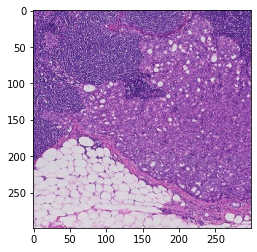

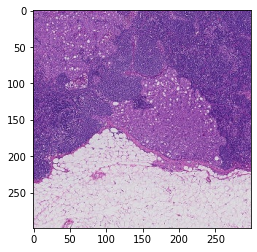

In [15]:
# check whether 'get_patches' function worked well (resizing, multiple level...)
plt.imshow(train_patch_images_lv1[50])
plt.show()
plt.imshow(train_patch_images_lv2[50])
plt.show()

In [16]:
# convert to array format
train_x1 = np.asarray(train_patch_images_lv1)
train_x2 = np.asarray(train_patch_images_lv2)
train_y = np.asarray(train_patch_labels)

del train_patch_images_lv1, train_patch_images_lv2, train_patch_labels

## Collect patches of test slide

In [65]:
# Download an test slide and tumor mask
slide_path_test = 'tumor_110.tif'
tumor_mask_path_test = 'tumor_110_mask.tif' 

slide_url = 'https://storage.googleapis.com/hw3_sk4985/%s' % slide_path_test
mask_url = 'https://storage.googleapis.com/hw3_sk4985/%s' % tumor_mask_path_test

# Download the whole slide image
if not os.path.exists(slide_path_test):
  !curl -O $slide_url

# Download the tumor mask
if not os.path.exists(tumor_mask_path_test):
  !curl -O $mask_url

In [66]:
# set parameters for test set
multi_level = [4,5]
patch_size = 299
center_size = 128
tissue_pct = 40
patch_limit = 100

# slide_path_test = 'tumor_081.tif'
# tumor_mask_path_test = 'tumor_081_mask.tif' 
slide_test = open_slide(slide_path_test)
tumor_mask_test = open_slide(tumor_mask_path_test)

In [19]:
# create patches for test slide
test_patch_images_lv1 = []
test_patch_images_lv2 = []
test_patch_labels = []

test_patch_images_lv1, test_patch_images_lv2, test_patch_labels = get_patches(slide_test, tumor_mask_test, multi_level, patch_size, center_size, tissue_pct, patch_limit)

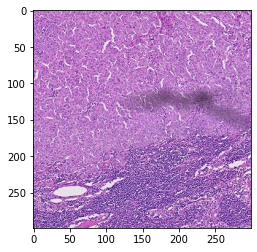

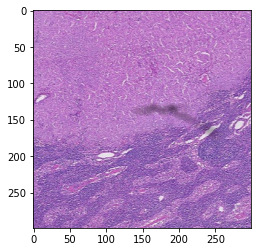

In [20]:
# check whether 'get_patches' function worked well (resizing, multiple level...)
plt.imshow(test_patch_images_lv1[50])
plt.show()
plt.imshow(test_patch_images_lv2[50])
plt.show()

In [21]:
# convert to array format
test_x1 = np.asarray(test_patch_images_lv1)
test_x2 = np.asarray(test_patch_images_lv2)
test_y = np.asarray(test_patch_labels)

del test_patch_images_lv1, test_patch_images_lv2, test_patch_labels

In [22]:
# save data
# np.save('test_x1.npy', test_x1)
# np.save('test_x2.npy', test_x2)
# np.save('test_y.npy', test_y)
# np.save('train_x1.npy', train_x1)
# np.save('train_x2.npy', train_x2)
# np.save('train_y.npy', train_y)

train_val_x1 = train_x1
train_val_x2 = train_x2
train_val_y = train_y

In [23]:
# split the train data into train and val
i = list(range(len(train_val_x1)))
np.random.shuffle(i)
train_i = i[:int(0.8*len(i))]
val_i = i[int(0.8*len(i)):]

train_x1 = train_val_x1[train_i]
train_x2 = train_val_x2[train_i]
train_y = train_val_y[train_i]

val_x1 = train_val_x1[val_i]
val_x2 = train_val_x2[val_i]
val_y = train_val_y[val_i]

In [24]:
print(train_x1.shape, train_y.shape, val_x1.shape, val_y.shape, test_x1.shape, test_y.shape)

(160, 299, 299, 3) (160,) (40, 299, 299, 3) (40,) (200, 299, 299, 3) (200,)


## ImageDataGenerator

In [33]:
def tozeroone(x):
    # normalize the value to [0,1]
    
    x = x.astype(float)
    x /= 255.
    return x

In [25]:
# I refer to 'https://techblog-history-younghunjo1.tistory.com/252' page
train_gen = ImageDataGenerator(horizontal_flip = True,
                               vertical_flip = True,
                               rescale=1./255.,
                               rotation_range = 90, 
                               preprocessing_function=None) 
val_gen = ImageDataGenerator(rescale=1./255.)

In [26]:
def train_datagen(train_x1, train_x2, train_y, random_seed = 42): 
  x1_gen = train_gen.flow(train_x1, train_y, seed = random_seed, batch_size=32)
  x2_gen = train_gen.flow(train_x2, seed = random_seed, batch_size=32)
  while True:
    x1_i = x1_gen.next()
    x2_i = x2_gen.next()
    yield [x1_i[0], x2_i], x1_i[1]

train_flow = train_datagen(train_x1, train_x2, train_y)

In [27]:
def val_datagen(val_x1, val_x2, val_y, random_seed = 42): 
  x1_gen = val_gen.flow(val_x1, val_y, seed = random_seed, batch_size=32)
  x2_gen = val_gen.flow(val_x2, seed = random_seed, batch_size=32)
  while True:
    x1_i = x1_gen.next()
    x2_i = x2_gen.next()
    yield [x1_i[0], x2_i], x1_i[1]

val_flow = val_datagen(val_x1, val_x2, val_y)

## Create Model

In [28]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

In [111]:
# use pretrained model inception_v3
# remove the final dense layer that performs classification (include_top=False)
# also import weights from imagenet
# specify the input shape to match the image

# base model for each level
base_model_lv1 = InceptionV3(input_shape=(patch_size, patch_size, 3),
                              include_top=False,
                              weights='imagenet')
base_model_lv2 = InceptionV3(input_shape=(patch_size, patch_size, 3),
                              include_top=False,
                              weights='imagenet')

# do not update the pretrained weights during training
# (we won't use finetuning here)
base_model_lv1.trainable = False
base_model_lv2.trainable = False

87910968/87910968 [==============================] - 1s 0us/step


In [112]:
base_model_lv1.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [125]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')

In [126]:
# build a new model reusing the pretrained base
model_lv1 = tf.keras.Sequential([
  base_model_lv1,
  global_average_layer
])

model_lv2 = tf.keras.Sequential([
  base_model_lv2,
  global_average_layer
])

input_lv1 = base_model_lv1.input
input_lv2 = base_model_lv2.input

merged = concatenate([model_lv1(input_lv1), model_lv2(input_lv2)])
merged = Dense(256, activation='relu')(merged)
prediction = prediction_layer(merged)
model = Model(inputs=[base_model_lv1.input, base_model_lv2.input], outputs=prediction)

In [127]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential_8 (Sequential)      (None, 2048)         21802784    ['input_1[0][0]']                
                                                                                            

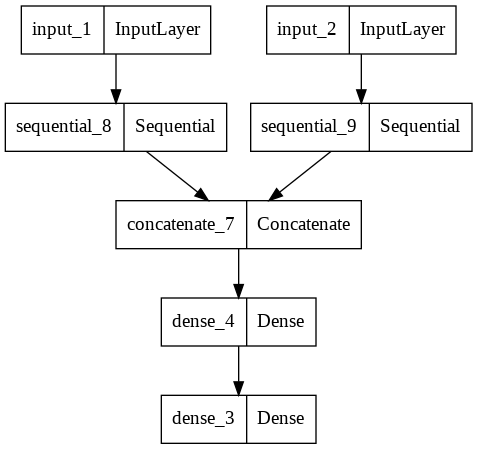

In [35]:
# You should not need to modify this.
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

In [129]:
# compile model
model.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [131]:
from keras.callbacks import EarlyStopping
batch_size = 16
early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0.001,
                               patience=3,
                               verbose=1)

history = model.fit_generator(train_flow,
                              epochs=7,
                              validation_data=val_flow, 
                              steps_per_epoch=len(train_x1)/batch_size+1, 
                              validation_steps=len(val_x1) / batch_size+1, 
                              callbacks = [early_stopping])

<ipython-input-131-3ef8b65a6630>:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_flow,


Epoch 1/7
11/11 [==============================] - 197s 18s/step - loss: 0.3539 - accuracy: 0.8523 - val_loss: 0.1467 - val_accuracy: 0.9500
Epoch 2/7
11/11 [==============================] - 207s 19s/step - loss: 0.2159 - accuracy: 0.9062 - val_loss: 0.1093 - val_accuracy: 0.9500
Epoch 3/7
11/11 [==============================] - 201s 19s/step - loss: 0.1737 - accuracy: 0.9205 - val_loss: 0.0637 - val_accuracy: 1.0000
Epoch 4/7
11/11 [==============================] - 203s 19s/step - loss: 0.1344 - accuracy: 0.9489 - val_loss: 0.0446 - val_accuracy: 1.0000
Epoch 5/7
11/11 [==============================] - 196s 18s/step - loss: 0.0899 - accuracy: 0.9659 - val_loss: 0.0678 - val_accuracy: 0.9750
Epoch 6/7
11/11 [==============================] - 201s 19s/step - loss: 0.0817 - accuracy: 0.9773 - val_loss: 0.0434 - val_accuracy: 1.0000
Epoch 7/7
11/11 [==============================] - 199s 18s/step - loss: 0.0748 - accuracy: 0.9773 - val_loss: 0.0368 - val_accuracy: 1.0000


In [ ]:
# save model
# model.save('model.h5')

In [30]:
# load model
# from keras.models import Model, load_model
# model = load_model('model.h5')

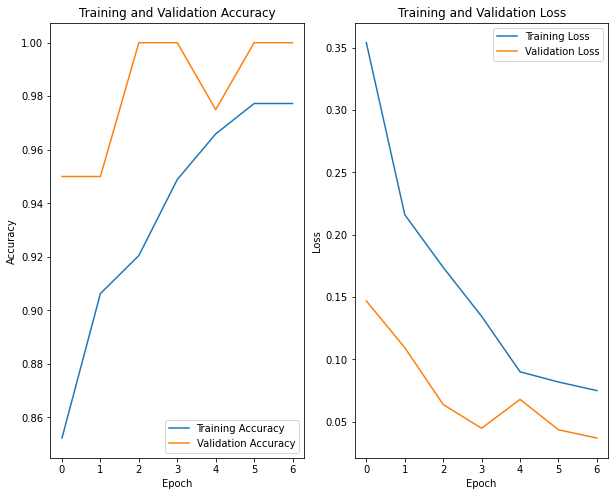

In [142]:
# Create plots of your training and validation loss and accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(7)

plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.title('Training and Validation Accuracy')
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.title('Training and Validation Loss')
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## Evaluate the model

In [134]:
# create test flow
test_gen = ImageDataGenerator(horizontal_flip = True,
                               vertical_flip = True,
                               rescale=1./255.,
                               rotation_range = 90, 
                               preprocessing_function=None) 

def test_datagen(test_x1, test_x2, test_y, random_seed = 28): 
  x1_gen = test_gen.flow(test_x1, test_y, seed = random_seed, batch_size=32)
  x2_gen = test_gen.flow(test_x2, seed = random_seed, batch_size=32)
  while True:
    x1_i = x1_gen.next()
    x2_i = x2_gen.next()
    yield [x1_i[0], x2_i], x1_i[1]

test_flow = test_datagen(test_x1, test_x2, test_y)
test_loss, test_acc = model.evaluate_generator(test_flow, steps=11)
print('Test loss: %.4f, Test accuracy: %.4f' % (test_loss, test_acc))

<ipython-input-134-2d7fc859fd17>:17: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_acc = model.evaluate_generator(test_flow, steps=11)


Test loss: 0.2368, Test accuracy: 0.9141


In [135]:
# visualize the image when making a predicting during evaluating the model on test data
from tensorflow.keras.utils import array_to_img

# extract sample
test_example = next(test_flow)
test_img = test_example[0]
test_lab = test_example[1]

# make a prediction
test_pred = model.predict([test_img[0], test_img[1]])

1/1 [==============================] - 13s 13s/step


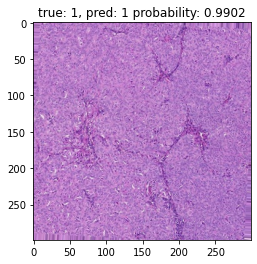

In [33]:
# plot the result1
img = array_to_img(test_img[0][1].reshape(patch_size,patch_size,3))
plt.imshow(img)

pred_score = test_pred[1][0]
pred_lab = int(pred_score>=0.5)

plt.title('true: '+ str(test_lab[1])+', pred: '+str(pred_lab) 
                  + ' probability: ' + str(round(pred_score,4)))
plt.show()

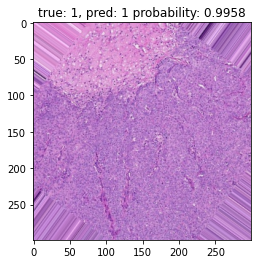

In [37]:
# plot the result2
img = array_to_img(test_img[0][2].reshape(patch_size,patch_size,3))
plt.imshow(img)

pred_score = test_pred[2][0]
pred_lab = int(pred_score>=0.5)

plt.title('true: '+ str(test_lab[2])+', pred: '+str(pred_lab) 
                  + ' probability: ' + str(round(pred_score,4)))
plt.show()

## Heatmaps & Metrics

In [32]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import gc
import cv2
import random, os, glob, time
from matplotlib.colors import Normalize
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, recall_score, precision_score

In [109]:
def patch_tumor(slide, level2, level1, patch_size, stride):

    # the input size is (299, 299), for each input we make a prediction of 
    # whether the center region of size (128, 128) contains tumor or not
    # predict the patch has tumor        
    
    patch_images_lvl1 = []
    patch_images_lvl2 = []
    
    slide_image_lvl1 = read_slide(slide, 
                       x=0, 
                       y=0, 
                       level=level1, 
                       width=slide.level_dimensions[level1][0], 
                       height=slide.level_dimensions[level1][1])
    
    slide_image_lvl2 = read_slide(slide, 
                       x=0, 
                       y=0, 
                       level=level2, 
                       width=slide.level_dimensions[level2][0], 
                       height=slide.level_dimensions[level2][1])
    
    result = []
    coord= []
    
    k=0
    # iterates and slides by stride size
    for i in range(0, slide.level_dimensions[level2][1] - patch_size - stride, stride):
      for j in range(0, slide.level_dimensions[level2][0] - patch_size - stride, stride):
        k += 1

        patch_lvl1 = slide_image_lvl1[i:i+patch_size, j:j+patch_size]
        patch_lvl2 = slide_image_lvl2[(i*2):(i*2)+patch_size, (j*2):(j*2)+patch_size]
        
        if(patch_lvl1.shape[0] == 0 or patch_lvl2.shape[0] == 0):
            continue            
        if(patch_lvl1.shape[0] != patch_size or patch_lvl1.shape[0] != patch_size):
            continue

        tissue_pixels = find_tissue_pixels(patch_lvl1)
        # tissue_pixels = list(tissue_pixels)
        percent_tissue = len(tissue_pixels) / float(patch_lvl1.shape[0] * patch_lvl1.shape[0]) * 100

        if percent_tissue > tissue_pct:
          patch_images_lvl1.append(patch_lvl1.astype('float32'))
          patch_images_lvl2.append(patch_lvl2.astype('float32'))
          coord.append([i,j])

        if len(patch_images_lvl1) == 256 and len(patch_images_lvl1) > 0:
          patch_images_lvl1 = np.asarray(patch_images_lvl1)
          
          if len(patch_images_lvl1.shape) == 4:
              
              patch_images_lvl2 = np.asarray(patch_images_lvl2)
              patch_images_lvl2 = tozeroone(patch_images_lvl2)

              patch_images_lvl1 = tozeroone(patch_images_lvl1)

              pred = model.predict([patch_images_lvl1, patch_images_lvl2])
              if len(pred[0]) == 2:
                pred = np.argmax(pred,axis = 1)
              result += list(pred)

          patch_images_lvl1 = []
          patch_images_lvl2 = []

    if len(patch_images_lvl1) != 0:
          patch_images_lvl1 = np.asarray(patch_images_lvl1)
          if len(patch_images_lvl1.shape) == 4: 

              patch_images_lvl2 = np.asarray(patch_images_lvl2)
              patch_images_lvl2 = tozeroone(patch_images_lvl2)

              patch_images_lvl1 = tozeroone(patch_images_lvl1)

              pred = model.predict([patch_images_lvl1, patch_images_lvl2])
              if len(pred[0]) == 2:
                pred = np.argmax(pred,axis = 1)
              result += list(pred)
          patch_images_lvl1 = []
          patch_images_lvl2 = []
          
    return result, coord

result, coord = patch_tumor(slide_test, 5, 6, patch_size, 20)

3/3 [==============================] - 23s 7s/step


In [107]:
def heatmap_score(slide, tumor_mask, result, patch_coord, level):

  # create the heatmap and get some metrics
  # that are appropriate to communicate how well the model performs
  
  slide_image = read_slide(slide, x=0, y=0, 
                         level=level, 
                         width=slide.level_dimensions[level][0], 
                         height=slide.level_dimensions[level][1])
  mask_image = np.asarray(read_slide(tumor_mask, x=0, y=0, 
                          level=level, 
                          width=slide.level_dimensions[level][0], 
                          height=slide.level_dimensions[level][1]))

  slide_image = np.asarray(slide_image)
  mask_temp = mask_image[:,:,0]
  mask_temp = np.zeros_like(mask_temp)

  for k, (i,j) in enumerate(coord):
    mask_temp[i:i+patch_size, j:j+patch_size] = 0 if result[k] < 0.25 else 255.

  plt.figure(figsize=(24,18))
  plt.subplot(1,2,1)
  plt.imshow(slide_image)
  plt.imshow(mask_image[:,:,0],cmap='jet', alpha=0.5)
  plt.subplot(1,2,2)
  plt.imshow(mask_image[:,:,0])
  plt.imshow(mask_temp, cmap='jet',alpha=0.5) 
  plt.show()

  fpr, tpr, thresholds = metrics.roc_curve(mask_image[:,:,0].reshape(-1).astype('float32'), 
                                           mask_temp.reshape(-1), pos_label=None)
  thres = thresholds[np.argmax(1-fpr+tpr)]

  mask_pred_labels = np.zeros(mask_temp.shape)
  mask_pred_labels[mask_temp >= thres] = 1.
  mask_pred_labels[mask_temp < thres] = 0.
  
  mask_image = mask_image[:,:,0].reshape(-1).astype('uint8')
  mask_pred_labels = mask_pred_labels.reshape(-1).astype('uint8')
  mat = confusion_matrix(mask_image, mask_pred_labels)

  recall = mat[1][1]/(mat[1][1]+mat[1][0])  
  precision = mat[1][1]/(mat[1][1]+mat[0][1])
  F1 = 2 * (precision * recall) / (precision + recall)

  print(f"auc score is {metrics.auc(fpr, tpr)}")
  print(f"precision score is {precision}")
  print(f"recall score is {recall}")
  print(f"f1_score is {F1}")

  plt.title('ROC curve')
  plt.xlabel('FPR')
  plt.ylabel('TPR')
  plt.plot(fpr, tpr)
  plt.show()

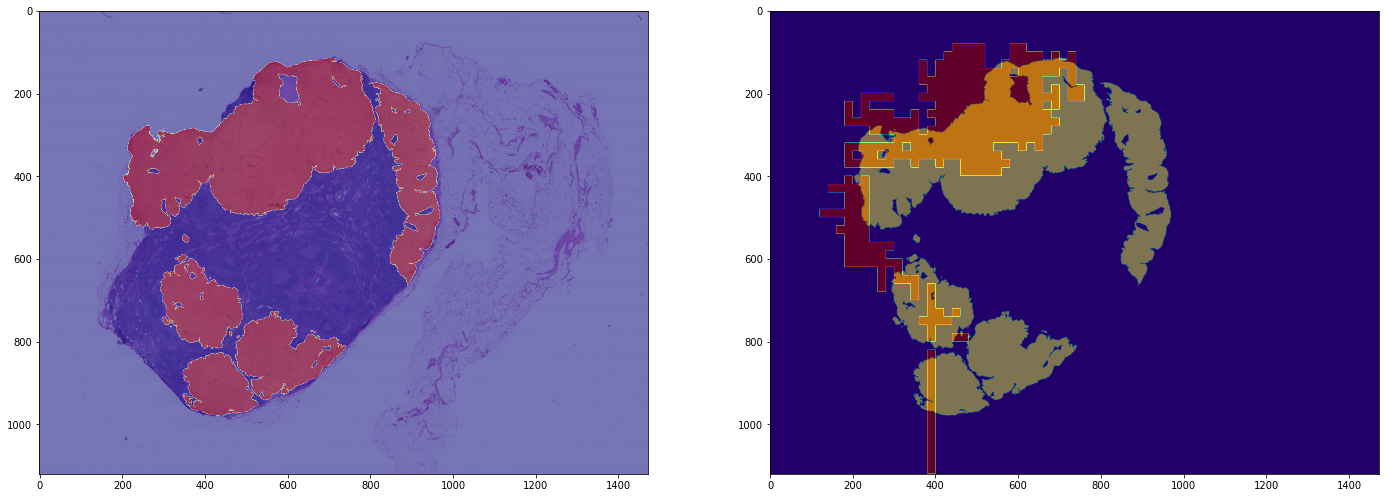

auc score is 0.6193032062924745
precision score is 0.5310624728221481
recall score is 0.2851017636965648
f1_score is 0.37102053939650176


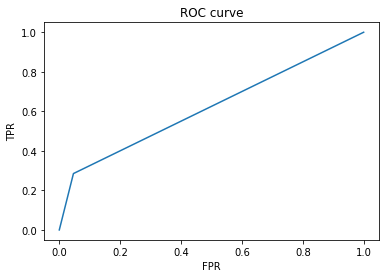

In [108]:
heatmap_score(slide_test, tumor_mask_test, result, coord, 6)